In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
from scipy.signal import find_peaks
from skimage.filters import butterworth
from scipy.ndimage import map_coordinates
import pims, sys
from pathlib import Path
#sys.path.insert(0, r'C:\\Warwick\\Jerko_Code_And_Docs\\Manuscript Code')
sys.path.insert(0, r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Jerko_files/Manuscript_Code/')
from Filament_Analysis.geometric_2 import SimpleSpline
import Filament_Analysis.various_funcs as var
from pathlib import Path
import pandas as pd
import trackpy as tp

### 1. Load the image series, the filament axis (or axes) and visualise.

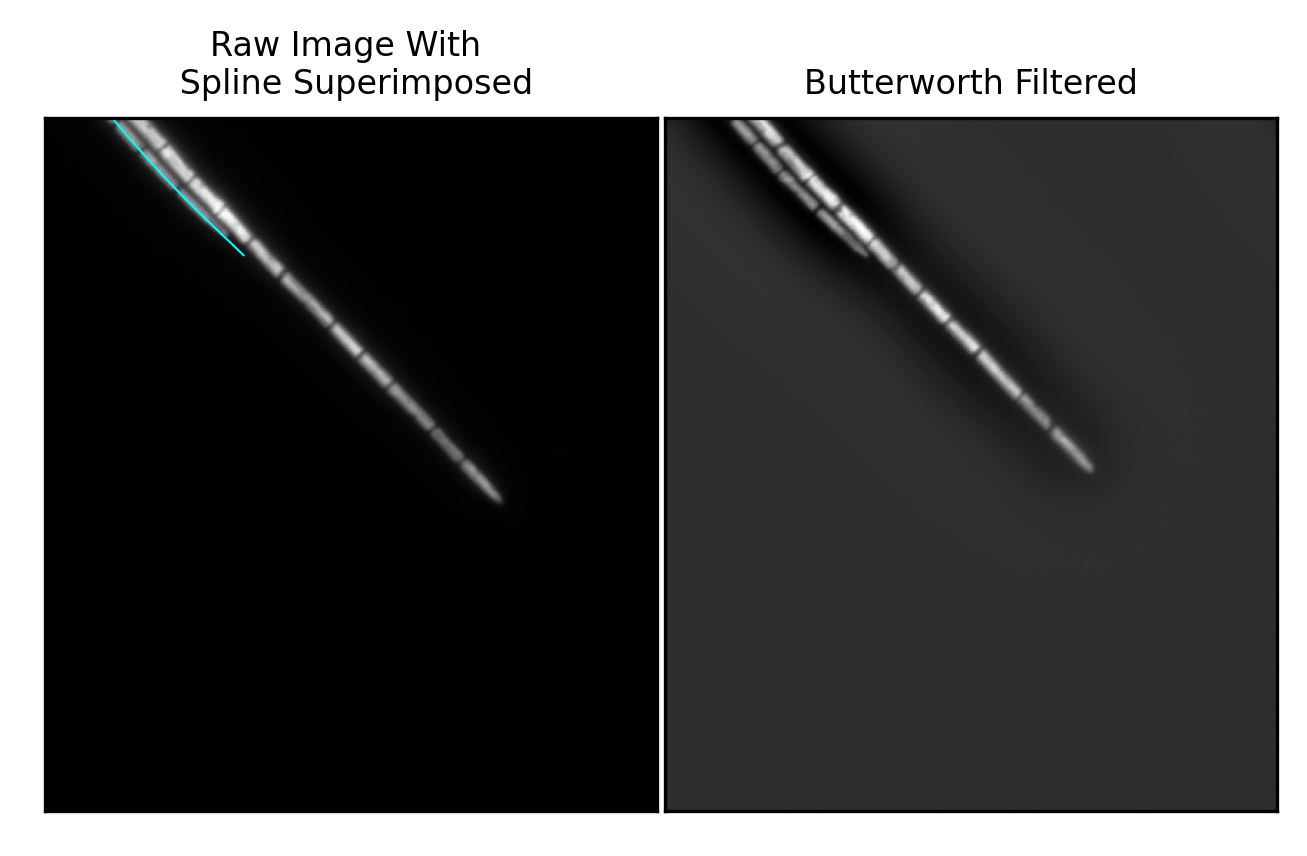

In [7]:
#base_path = Path(r'C:\Users\jrosk\Dropbox\Warwick\TIRF\February_2023\22-02-2023\Untreated_Sample')
base_path = Path(r'/Volumes/shared/Shared279/OSSLAB_projectsShared/cyanoMotility_story/data_TIRF/22-02-2023/Untreated_Sample')

#file_path_0 = base_path.joinpath(r'Slides\Slide_1\22-Feb-23_tirf-5.tif')
file_path_0 = base_path.joinpath(r'Slides/Slide_1/22-Feb-23_tirf-5.tif')

#axis_path_0 = Path('splines\spline_0.txt')
axis_path_0 = Path('splines/spline_0.txt')

# Create a SimpleSpline object containing the filament axis
axis_0 = SimpleSpline.from_csv(axis_path_0, 0.01)



# This is to crop the stack, so that we only have the red channel
@pims.pipeline
def red_channel(frame):
    return frame[:,428:]

@pims.pipeline
def green_channel(frame):
    return frame[:,:428]

both_channels = pims.open(file_path_0.as_posix())

# Apply pipeline
images_red = red_channel(both_channels)
images_green = green_channel(both_channels)

#Sometimes the spline goes beyond the image dimensions and causes issues
axis_0.crop_to_image_dimensions(images_red[0].shape)

# Visualise the spline
with plt.style.context('seaborn-v0_8-paper'):
    fig , ax = plt.subplots(1,2, figsize=(6,3), dpi=300)
    ylim = (images_red[400].shape[0],200)
    ax[0].imshow(-images_red[400], cmap='Greys')
    ax[0].plot(axis_0.xy[:,0], axis_0.xy[:,1], color='cyan', linewidth = 0.5)
    ax[0].set_title('Raw Image With \n Spline Superimposed', fontsize=8)
    ax[1].imshow(-butterworth(images_red[600],cutoff_frequency_ratio=0.01), cmap = 'Greys')
    ax[1].set_title('Butterworth Filtered', fontsize=8)
    for axis in ax:
        axis.set(ylim=ylim,xticks=[],yticks=[])
        axis.grid(False)
    plt.subplots_adjust(wspace=-0.2)
    plt.show()

### 2. Run an intensity profile along the `filament_axis` for the first image. Smooth and find dips corresponding to septae.

- Tweak `cutoff_frequency_ratio` in `butterworth()` and both `prominence` and `distance` in `find_peaks()`

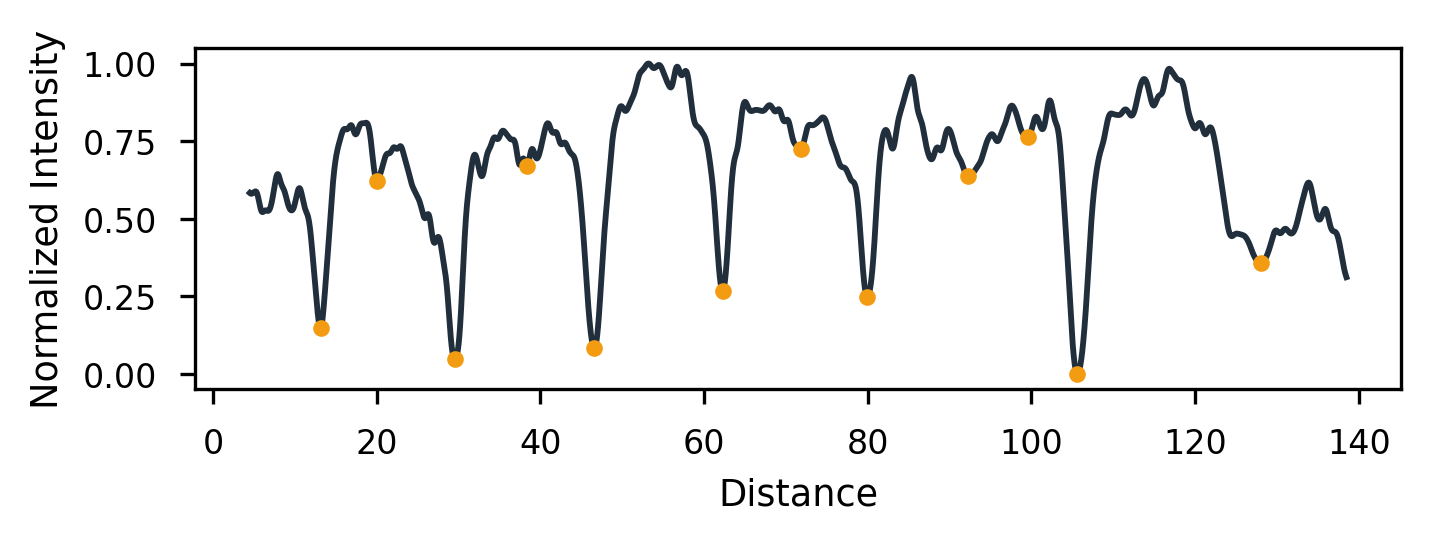

In [3]:
profile = map_coordinates(butterworth(images_red[600],cutoff_frequency_ratio=0.01), axis_0.xy[:, [1, 0]].T)
profile = profile / np.max(profile)
peaks, *params = find_peaks(-profile, prominence = 0.1, distance=600)

with plt.style.context('seaborn-v0_8-paper'):
    fig , ax = plt.subplots(1,1, figsize=(4.8,1.85), dpi=300)
    ax.plot(axis_0.xy[:,0], profile,'-', color='#212f3c')
 
    for peak in peaks:
        ax.plot(axis_0.xy[peak,0],profile[peak], 'o', color='#f39c12', markersize=4)

    ax.set_ylabel('Normalized Intensity')
    ax.set_xlabel('Distance')
    plt.tight_layout()
    plt.grid(False)
    plt.show()

> 3. Iterate over the entire image series, save `x` positions of the peaks, their `frame`, and peak prominences as `params`. Create a `pandas.DataFrame` containing peaks `x`, `frames`, `prominences` and a dummy value for `y`so that trackpy works to track and link them all

In [4]:
from skimage.filters import gaussian
all_peaks_x, all_peaks_frame, all_params = [], [], []

total_frame_length = len(images_red)

for n in range(total_frame_length):
    if n%500 == 0:
        print(f'processed {n} images')
    
    if n < len(images_red): # This is here for convenience when I analyse a video with several stacks that need concatenating.
        image = images_red[n]
    else:
        break
    #profile = map_coordinates(gaussian(image), axis_0.xy[:, [1, 0]].T)
    profile = map_coordinates(butterworth(image,cutoff_frequency_ratio=0.01), axis_0.xy[:, [1, 0]].T)
    profile = profile/np.max(profile)
    peaks, *params = find_peaks(-profile, prominence = 0.03, distance=600)
    
    for k,peak in enumerate(peaks):
        all_peaks_x.append(axis_0.xy[:,0][peak])
        all_peaks_frame.append(n)
        all_params.append(params[0]['prominences'][k])
    
data = [all_peaks_frame, all_peaks_x, [1]*len(all_peaks_x), all_params]
septae_dataframe = pd.DataFrame(list(zip(*data)), columns=['frame', 'x', 'y', 'params'])



processed 0 images
processed 500 images
processed 1000 images


Frame 1481: 5 trajectories present.


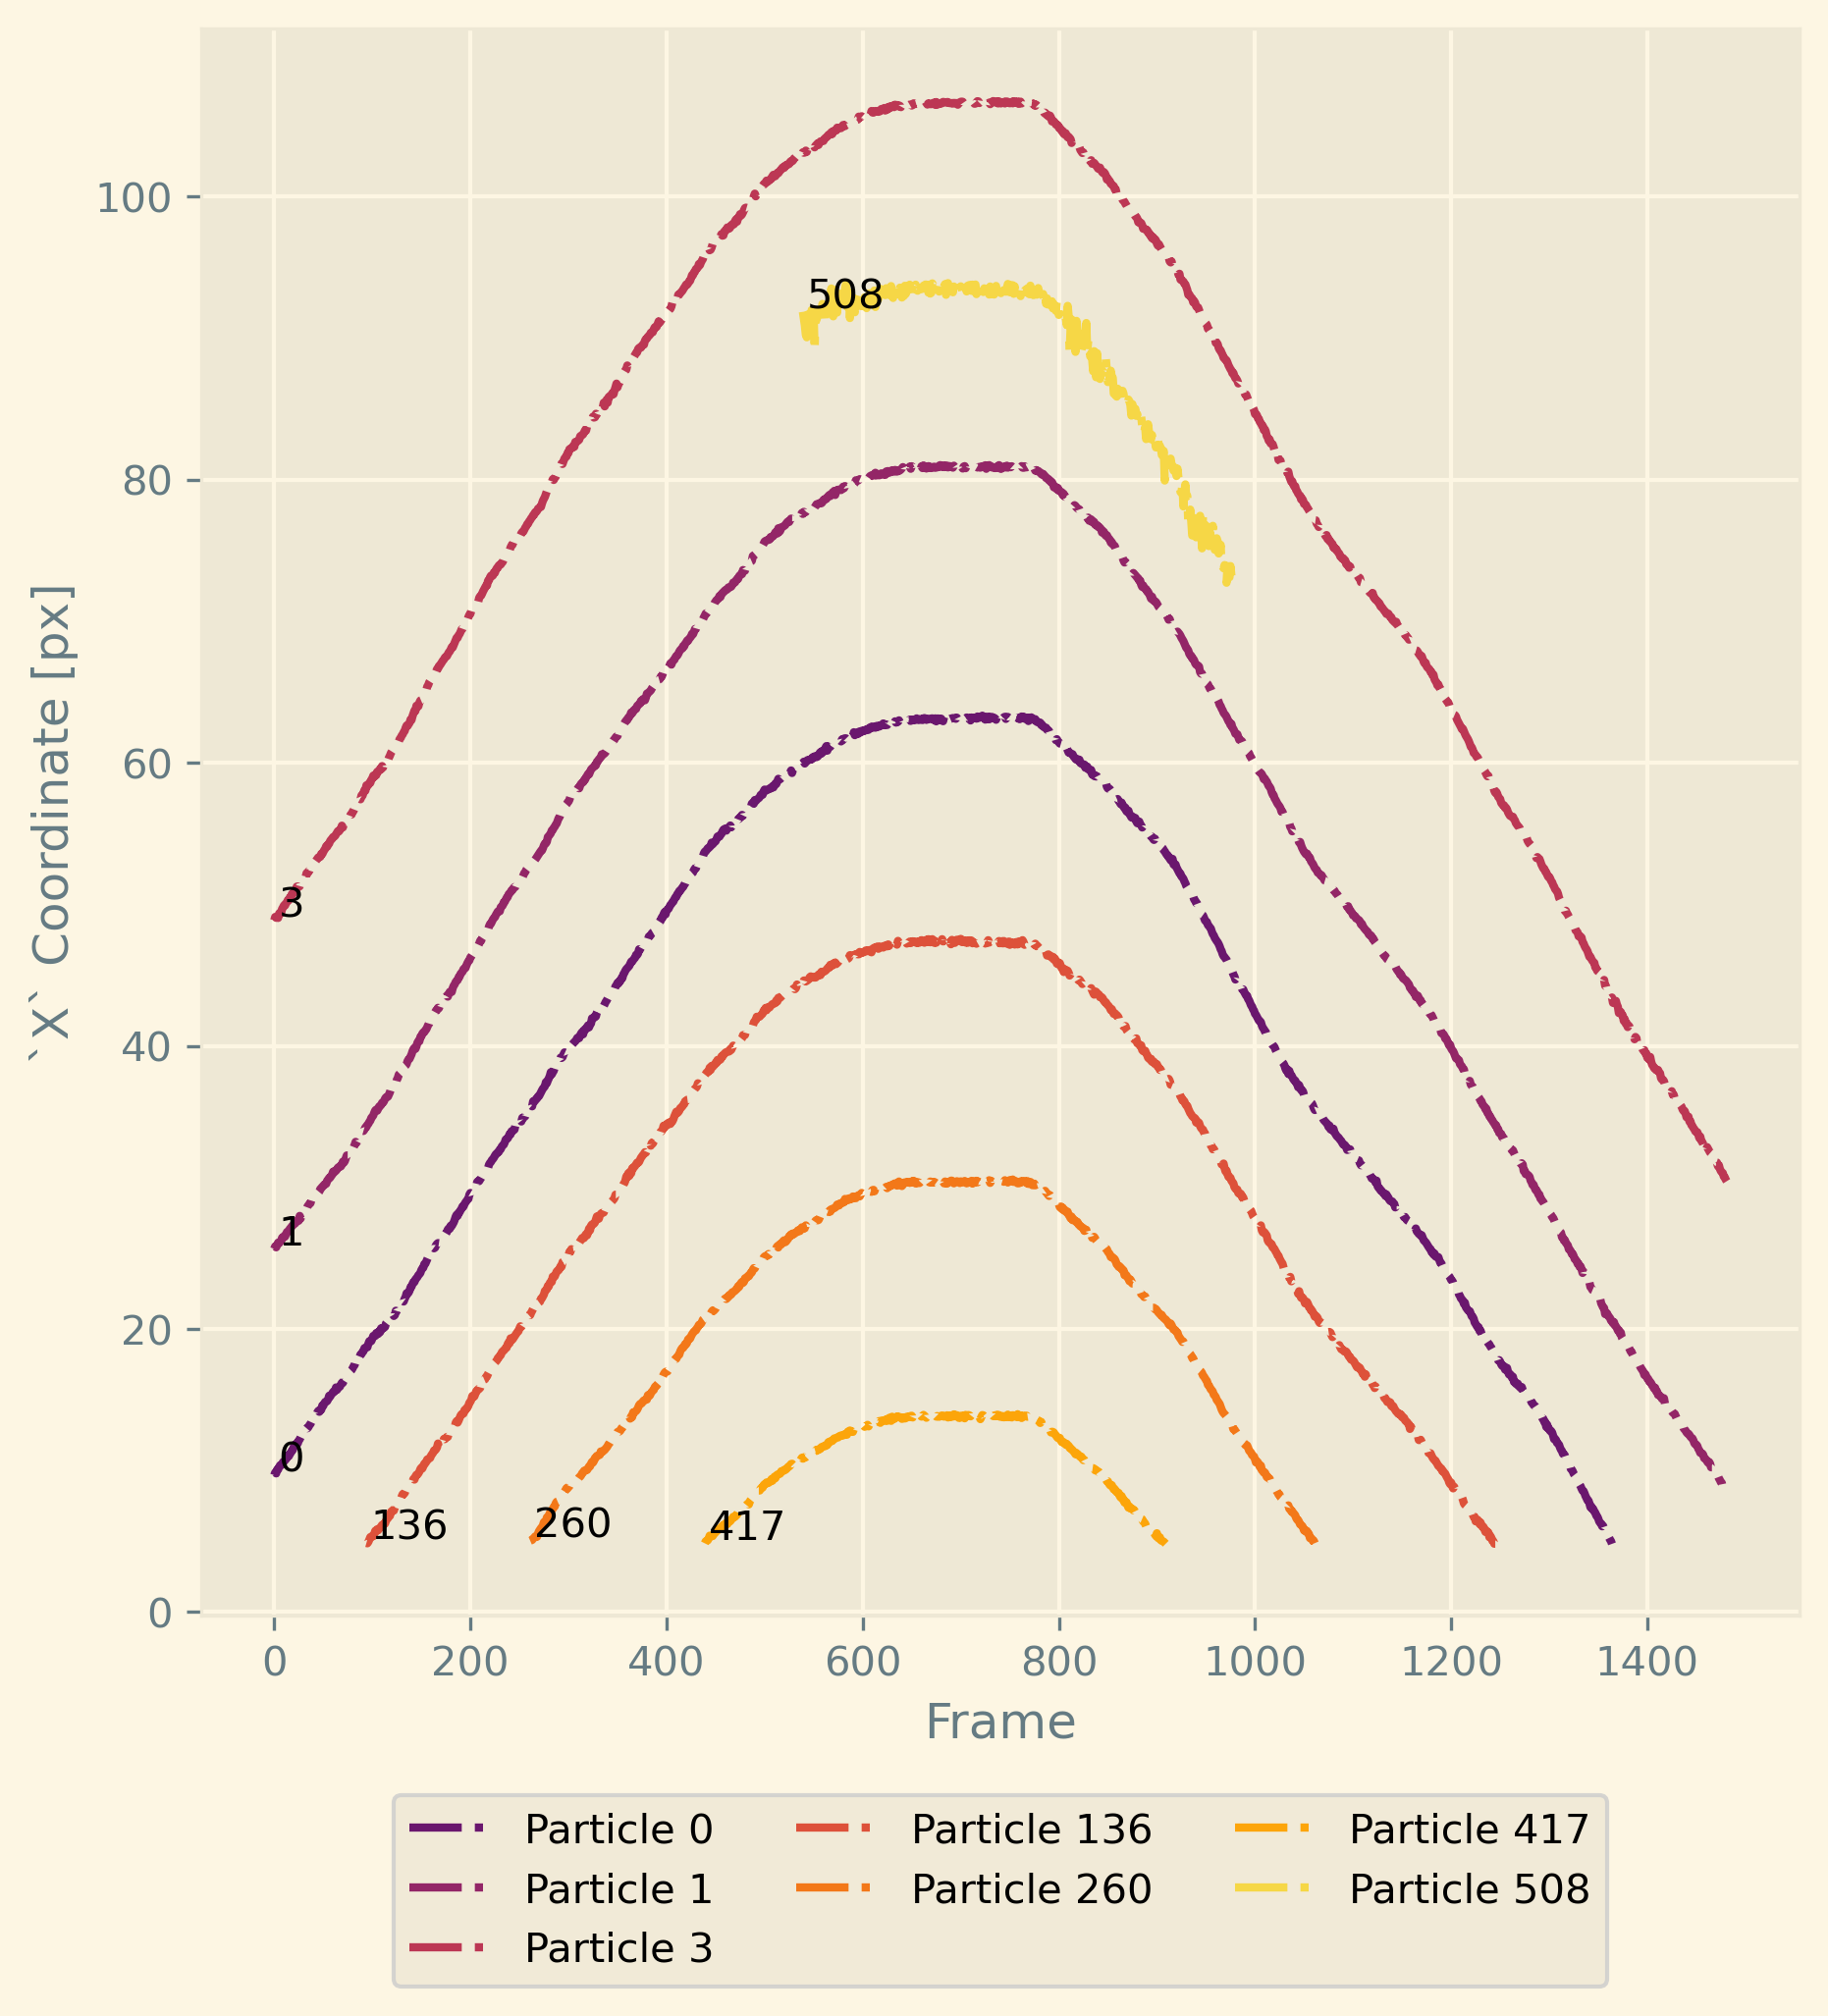

In [8]:
# Link and remove short trajectories
linked = tp.link(septae_dataframe,3, memory = 1)
linked = tp.filter_stubs(linked, 400)
linked.drop('y', axis=1, inplace=True)


#Visualise
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(1, 1, figsize=(7, 7), dpi=300)
    ax = var.ax_plot_septae(ax,linked, params_dict={'x_label' : 'Frame', 'y_label':'`X` Coordinate [px]'})
    plt.show() 

> 4. 

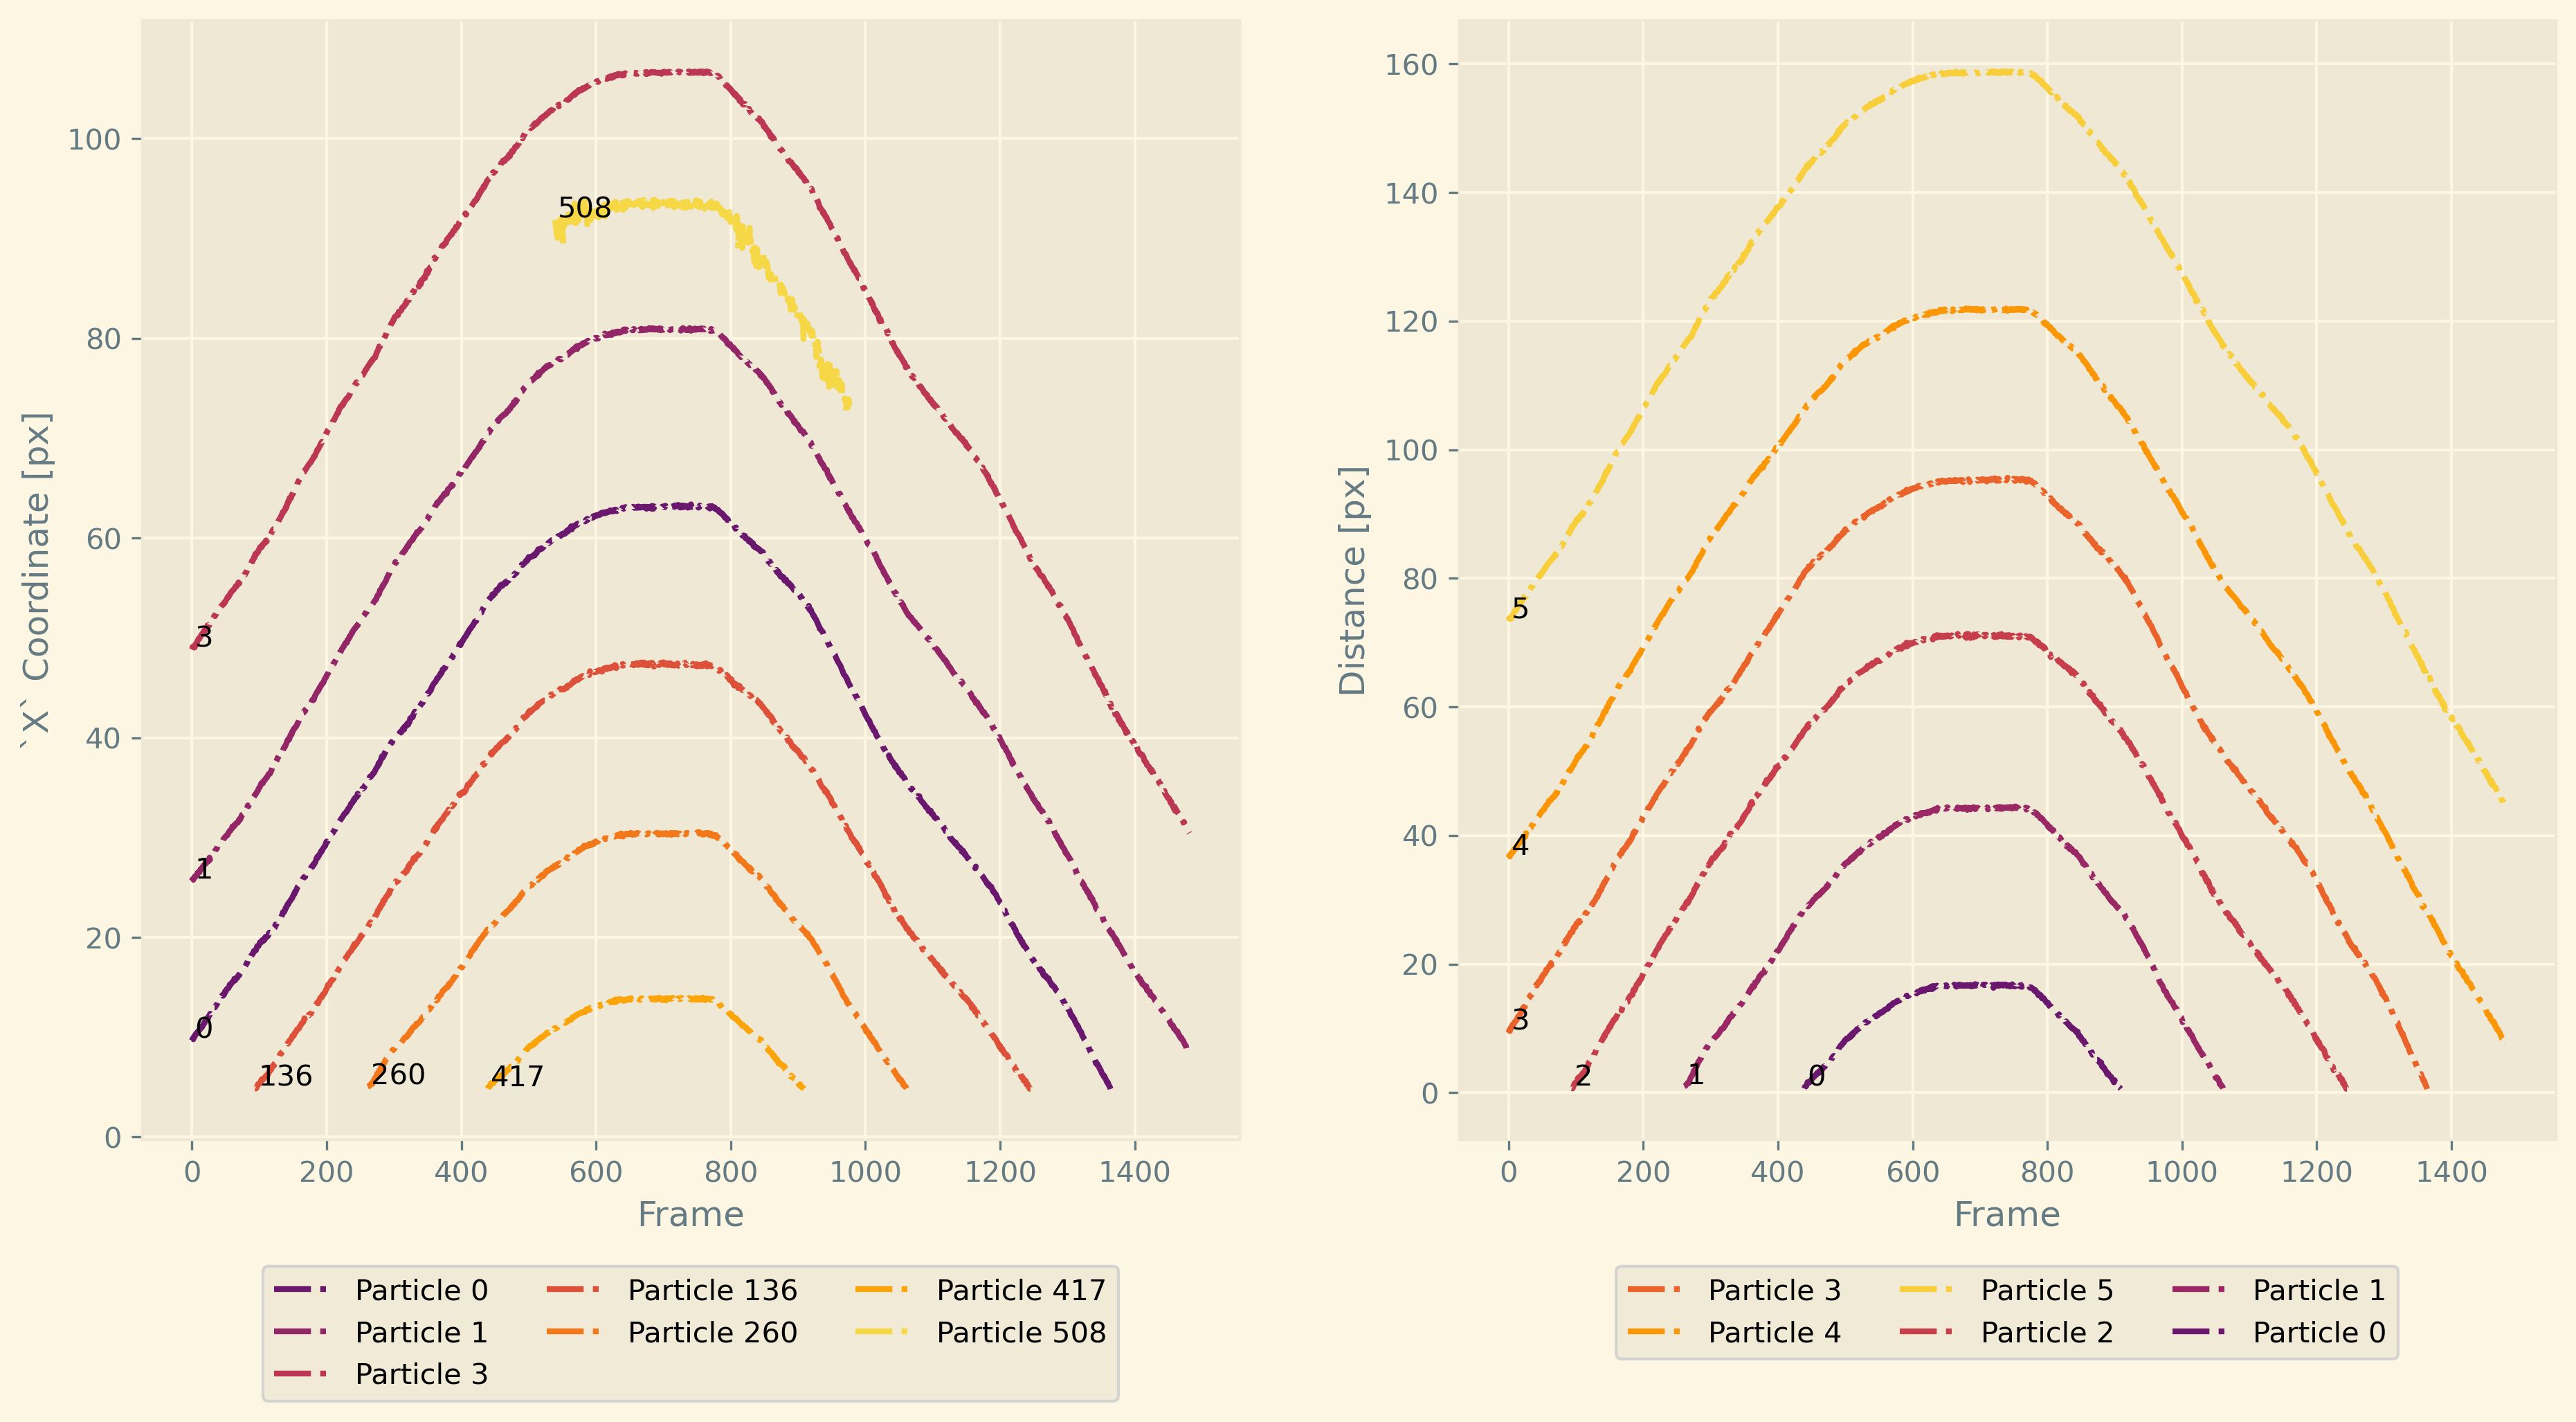

In [9]:
# Apply filters and calculate distance 

# Start from .isin([]) here and add the unwanted integer ID's after the first run, then re-run
linked_filtered = linked.loc[~linked['particle'].isin([508])].copy()

# Convert 'x' to distance on the spline
linked_filtered['distance'] = linked_filtered['x'].apply(axis_0.integrate_distance, args=(axis_0.xy[0,0],))

# Pass a frame_range in which all the trajectories, that we are keeping, are present
# Then the function will change their integer ID to reflect nearest-furthest in the `frame_range`
linked_filtered = var.sort_particles(linked_filtered, frame_range = [600, 605])

# Visualise
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(1, 2, figsize=(15, 7), dpi=300)
    ax[0] = var.ax_plot_septae(ax[0],linked, params_dict={'x_label' : 'Frame', 'y_label':'`X` Coordinate [px]'})
    ax[1] = var.ax_plot_septae(ax[1],linked_filtered, pos_col = 'distance', sorted=True, params_dict={'x_label' : 'Frame', 'y_label':'Distance [px]'})
    plt.show()


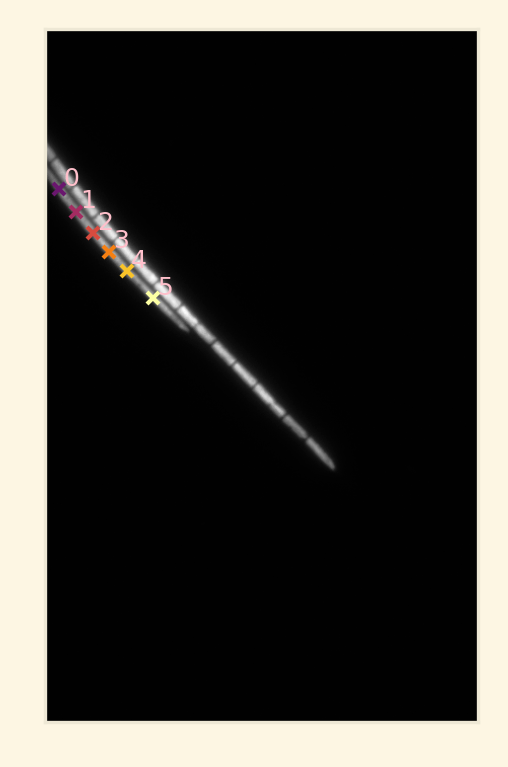

In [10]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=300)
    ax.imshow(-images_red[700], cmap='Greys')
    ax = var.ax_septae_on_image(ax, linked_filtered, images_red[700], axis_0, marker_size=3, font_size=6)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    plt.show()


In [11]:
linked_filtered.to_csv('linked_septae_bot.csv')